# Text processing

## Init spark

In [2]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, Row
from pyspark.sql import SparkSession

sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

## Dummy data

In [3]:


books_rdd_list = []
directory = r'data/'
for filename in os.listdir(directory):
    txt = open("data/"+filename).read()
    row = Row(id=filename.replace('.txt',''), text=txt)
    # row = Row(texts=txt)
    books_rdd_list.append(row)
rdd = sc.parallelize(books_rdd_list)
df = rdd.flatMap(lambda x: (x,)).toDF() 

df.show()

+-----+--------------------+
|   id|                text|
+-----+--------------------+
|10010|The Project Guten...|
|10019|Project Gutenberg...|
| 1002|The Project Guten...|
|10020|The Project Guten...|
|10037|Project Gutenberg...|
|10042|The Project Guten...|
|10046|The Project Guten...|
|10061|The Project Guten...|
|10074|The Project Guten...|
|10077|The Project Guten...|
|10088|The Project Guten...|
|10090|The Project Guten...|
|10098|The Project Guten...|
|10109|The Project Guten...|
|10110|The Project Guten...|
|10111|The Project Guten...|
|10119|The Project Guten...|
|10130|The Project Guten...|
|10144|The Project Guten...|
|10149|The Project Guten...|
+-----+--------------------+
only showing top 20 rows



In [4]:
%%time
import re
import unidecode
from pyspark.sql.types import *
from pyspark.sql.functions import udf

def clean(text):
    text = unidecode.unidecode(text) # remove accents
    text = text.lower()
    text = text.replace(r'\n','') # remove newline sign
    text = re.sub(r'\d+', '', text) # remove digits 
    text = re.sub(r'[.]?-[.]?', '', text) # concatenate divided words
    text = re.sub(r'[\W]+',' ', text) # replace non-alphanum with space  
    text = re.sub(' +', ' ', text) # replace multiple spaces with single space 
    return text

user_def_fun = udf(f=clean, returnType=StringType())

df = df.withColumn("cleaned", user_def_fun("text"))
df.show(2)
df = df.drop('text')

+-----+--------------------+--------------------+
|   id|                text|             cleaned|
+-----+--------------------+--------------------+
|10010|The Project Guten...|the project guten...|
|10019|Project Gutenberg...|project gutenberg...|
+-----+--------------------+--------------------+
only showing top 2 rows

Wall time: 9.79 s


## Tokenization

In [5]:
%%time
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="cleaned", outputCol="tokens")
df = tokenizer.transform(df)
df.show(2)
df = df.drop('cleaned')

Py4JJavaError: An error occurred while calling o71.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 3, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.lang.StringCoding$StringDecoder.decode(Unknown Source)
	at java.lang.StringCoding.decode(Unknown Source)
	at java.lang.String.<init>(Unknown Source)
	at java.lang.String.<init>(Unknown Source)
	at net.razorvine.pickle.Unpickler.load_binunicode(Unpickler.java:474)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:190)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$evaluate$1.apply(BatchEvalPythonExec.scala:90)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$evaluate$1.apply(BatchEvalPythonExec.scala:89)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.lang.StringCoding$StringDecoder.decode(Unknown Source)
	at java.lang.StringCoding.decode(Unknown Source)
	at java.lang.String.<init>(Unknown Source)
	at java.lang.String.<init>(Unknown Source)
	at net.razorvine.pickle.Unpickler.load_binunicode(Unpickler.java:474)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:190)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$evaluate$1.apply(BatchEvalPythonExec.scala:90)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$evaluate$1.apply(BatchEvalPythonExec.scala:89)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)


## Stopwords Removal

In [1]:
%%time
from pyspark.ml.feature import StopWordsRemover

stopword_removal = StopWordsRemover(inputCol='tokens', 
                                    outputCol='refined_tokens')
df = stopword_removal.transform(df)
df.show(2)
df = df.drop('tokens')

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

## Stemming vs lemmatization

### SnowballStemmer

In [10]:
%%time
from nltk.stem.snowball import SnowballStemmer

def list_stemmer(words):
    stemmer = SnowballStemmer(language='english')
    return [stemmer.stem(word) for word in words]

stemming = udf(list_stemmer, returnType=ArrayType(StringType()))

df = df.withColumn("stem", stemming("refined_tokens"))
df.show(2)
# comment below line if you want to check also WordNetLemmatizer
df = df.drop("refined_tokens")

Py4JJavaError: An error occurred while calling o217.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7.0 (TID 7, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Dell\Desktop\Spark\spark-2.4.5-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 362, in main
  File "C:\Users\Dell\Desktop\Spark\spark-2.4.5-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 722, in read_int
    length = stream.read(4)
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python37-32\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Dell\Desktop\Spark\spark-2.4.5-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 362, in main
  File "C:\Users\Dell\Desktop\Spark\spark-2.4.5-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 722, in read_int
    length = stream.read(4)
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python37-32\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


### WordNetLemmatizer

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
%%time
from nltk.stem import WordNetLemmatizer

def list_lemmatizer(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

lemmatization = udf(list_lemmatizer, returnType=ArrayType(StringType()))

df = df.withColumn("lem", lemmatization("refined_tokens"))
df.select(['refined_tokens','lem']).show(2)

OSError: [WinError 123] Nazwa pliku, nazwa katalogu lub składnia etykiety woluminu jest niepoprawna: 'C:\\Users\\Dell\\Desktop\\Spark\\spark-2.4.5-bin-hadoop2.7\\python\\lib\\py4j-<version>-src.zip:%PYTHONPATH%'

## TF-IDF

In [9]:
%%time
from pyspark.ml.feature import HashingTF, IDF

hashing_vec = HashingTF(numFeatures=262144,
                        inputCol='stem',
                        outputCol='tf_features')

hashing_df = hashing_vec.transform(df)
hashing_df.select(['stem','tf_features']).show(2)

IllegalArgumentException: 'Field "stem" does not exist.\nAvailable fields: id, refined_tokens'

In [80]:
%%time
tf_idf_vec = IDF(inputCol='tf_features',
               outputCol='tf_idf_features')

tf_idf_df = tf_idf_vec.fit(hashing_df).transform(hashing_df)
tf_idf_df.select(['stem','tf_idf_features']).show(2)
tf_idf_df = tf_idf_df.drop(*['stem','tf_features']) 

+--------------------+--------------------+
|                stem|     tf_idf_features|
+--------------------+--------------------+
|[seneca, apocoloc...|(262144,[211,288,...|
|[eulog, howard, v...|(262144,[22,135,2...|
+--------------------+--------------------+
only showing top 2 rows

CPU times: user 3.13 ms, sys: 18.8 ms, total: 21.9 ms
Wall time: 6.12 s


In [81]:
tf_idf_df.show()

+--------------------+--------------------+
|               title|     tf_idf_features|
+--------------------+--------------------+
|     Apocolocyntosis|(262144,[211,288,...|
|The Eulogies of H...|(262144,[22,135,2...|
|My First Years As...|(262144,[43,216,3...|
+--------------------+--------------------+



# Reduction of dimensions
## PCA

### Explained variance for k principal components  

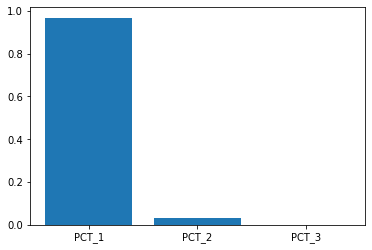

CPU times: user 324 ms, sys: 178 ms, total: 502 ms
Wall time: 47.8 s


In [25]:
%%time
from pyspark.ml.feature import PCA 
from pyspark.ml.linalg import Vectors

k = 10
pca = PCA(k=k, inputCol='tf_idf_features', outputCol="pca")
model = pca.fit(tf_idf_df)
exp_var = model.explainedVariance.values
plt.bar(['PCT_' + str(i+1) for i in range(exp_var.shape[0])], exp_var)
plt.show()

### Dimensionality reduction

In [83]:
%%time

pca = PCA(k=2, inputCol='tf_idf_features', outputCol="pca")
model = pca.fit(tf_idf_df)
transformed = model.transform(tf_idf_df)
transformed.show(2) 
transformed = transformed.drop('tf_idf_features') 

+--------------------+--------------------+--------------------+
|               title|     tf_idf_features|                 pca|
+--------------------+--------------------+--------------------+
|     Apocolocyntosis|(262144,[211,288,...|[0.95073949982433...|
|The Eulogies of H...|(262144,[22,135,2...|[-3.6876016445318...|
+--------------------+--------------------+--------------------+
only showing top 2 rows

CPU times: user 25.8 ms, sys: 1.53 ms, total: 27.3 ms
Wall time: 21.7 s


### split vectors in to two columns

In [89]:
from pyspark.sql import Row
from pyspark.sql.types import *

two_columns_rdd = transformed.rdd.map(lambda x: Row(title=str(x[0]),
                                                    PCA_1=float(x[1][0]), 
                                                    PCA_2=float(x[1][1])))

schema = StructType([StructField("title", StringType(), True),
                     StructField("PCA_1", FloatType(), True),
                     StructField("PCA_2", FloatType(), True)])

pca_df = spark.createDataFrame(two_columns_rdd, schema=schema)
pca_df.show(2)

+--------------------+----------+----------+
|               title|     PCA_1|     PCA_2|
+--------------------+----------+----------+
|     Apocolocyntosis| 0.9507395|-15.724105|
|The Eulogies of H...|-3.6876016|  67.62365|
+--------------------+----------+----------+
only showing top 2 rows



# Visualization

In [104]:
plot_df = pca_df.toPandas()
x =plot_df['PCA_1'].values
y = plot_df['PCA_2'].values
titles = plot_df['title'].values

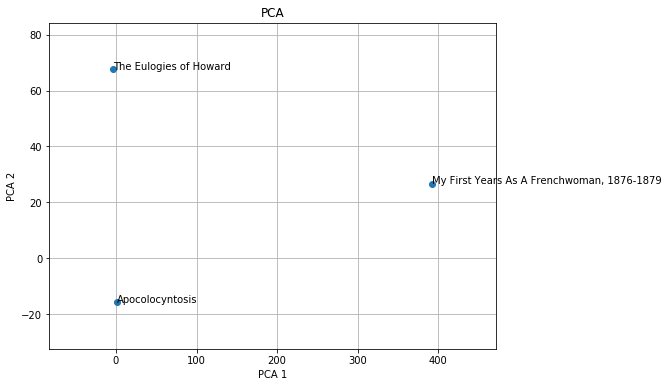

In [105]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)
ax.scatter(x,y, zorder=3)

# Display titles
for i, title in enumerate(titles):
    ax.annotate(title, (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()

# Cluster analysis

## Selecting the number of clusters with silhouette analysis on KMeans clustering

For n_clusters = 2 The average silhouette_score is : 0.120782815


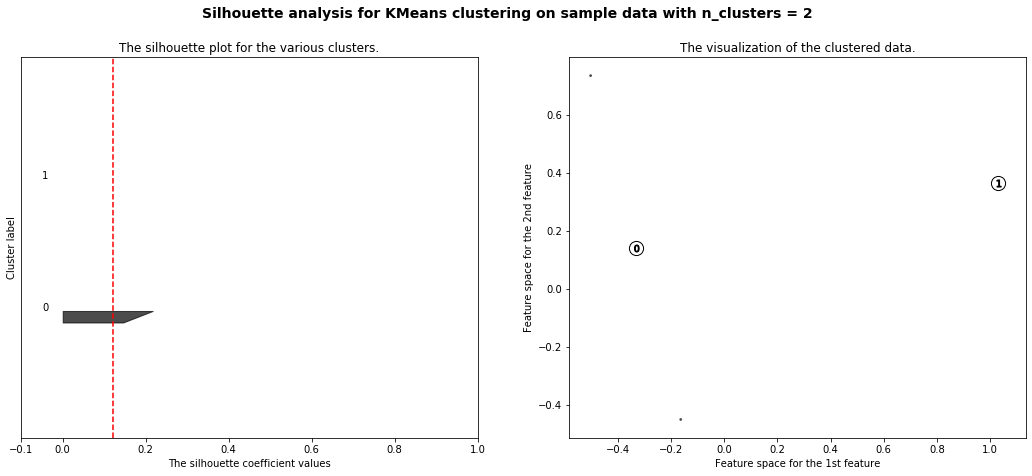

In [22]:
from silhouette_analysis import *

silhouette_plot(plot_df.values, range_n_clusters=[2])

## Clusterization

In [178]:
from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters=3,
                          max_iter=100,
                          n_jobs=-1)

labels = clustering_model.fit_predict(plot_df)

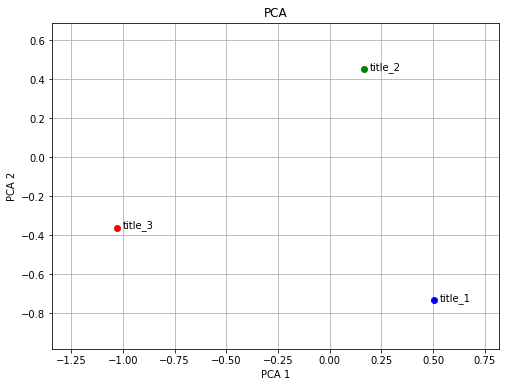

In [186]:
color_map = {0: 'red', 
             1: 'green', 
             2: 'blue'}
    
titles = ['title_1','title_2','title_3']

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)

for i, _ in enumerate(x):
    # Add colors
    color = color_map[labels[i]]
    ax.scatter(x[i], y[i], c=color, zorder=3)
    # Display titles
    ax.annotate(titles[i], (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()